In [1]:
#Standard Packages:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import time
import seaborn as sns


#Statsmodels:
import statsmodels.api as sma
import statsmodels as sm
from statsmodels import tsa
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import t, probplot

In [2]:
# read daily close price data
file_path = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_CRSP_daily_data_alltime.csv'
df = pd.read_csv(file_path)

# Ensure that the date column is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Keep both the 'date' and 'PRC' columns
df = df[["date", "PRC"]].copy()

print(df.head())

        date    PRC
0 1925-12-31  46.00
1 1926-01-02  46.00
2 1926-01-04  45.50
3 1926-01-05  45.25
4 1926-01-06  45.00


In [3]:
# Set 'date' as the index
df.set_index('date', inplace=True)

# Resample and keep only the last available price of each week
f = 'W-SUN' # 'W-SUN' means week ending on Sunday
df = df.resample(f).last()  

# Reset index if you want 'date' as a column again
#df.reset_index(inplace=True)

# Show the first few rows of the resulting DataFrame
print(df.head())


               PRC
date              
1926-01-03  46.000
1926-01-10  45.250
1926-01-17  43.875
1926-01-24  43.625
1926-01-31  45.250


In [4]:
# check for missing values
print("Missing values:", df.isnull().sum())
# remove missing values
df = df.dropna()

print(df.head())

Missing values: PRC    1
dtype: int64
               PRC
date              
1926-01-03  46.000
1926-01-10  45.250
1926-01-17  43.875
1926-01-24  43.625
1926-01-31  45.250


In [5]:
# Display summary statistics
df['PRC'].describe()

count    5113.000000
mean       64.109692
std        20.174228
min        20.500000
25%        47.875000
50%        63.375000
75%        78.100000
max       168.500000
Name: PRC, dtype: float64

In [6]:
start_date = '2016-1-30'
end_train_date = '2017-9-30'

# Filter the data according to the date range
train_data = df[(df.index >= start_date) & (df.index <= end_train_date)]
test_data = df[(df.index >= train_data.index[-1])]

In [7]:
# Augmented Dickey Fuller (ADF) test to check if the price is stationary

from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_result = adfuller(train_data['PRC'])

# Print the result of the ADF test
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Used Lag:", adf_result[2])
print("Number of Observations Used:", adf_result[3])
print("Critical Values:", adf_result[4])
print("Conclusion: The series is stationary" if adf_result[1] < 0.05 else "Conclusion: The series is non-stationary")


ADF Statistic: -1.8528418334443082
p-value: 0.35456034204616693
Used Lag: 0
Number of Observations Used: 86
Critical Values: {'1%': -3.5087828609430614, '5%': -2.895783561573195, '10%': -2.5850381719848565}
Conclusion: The series is non-stationary


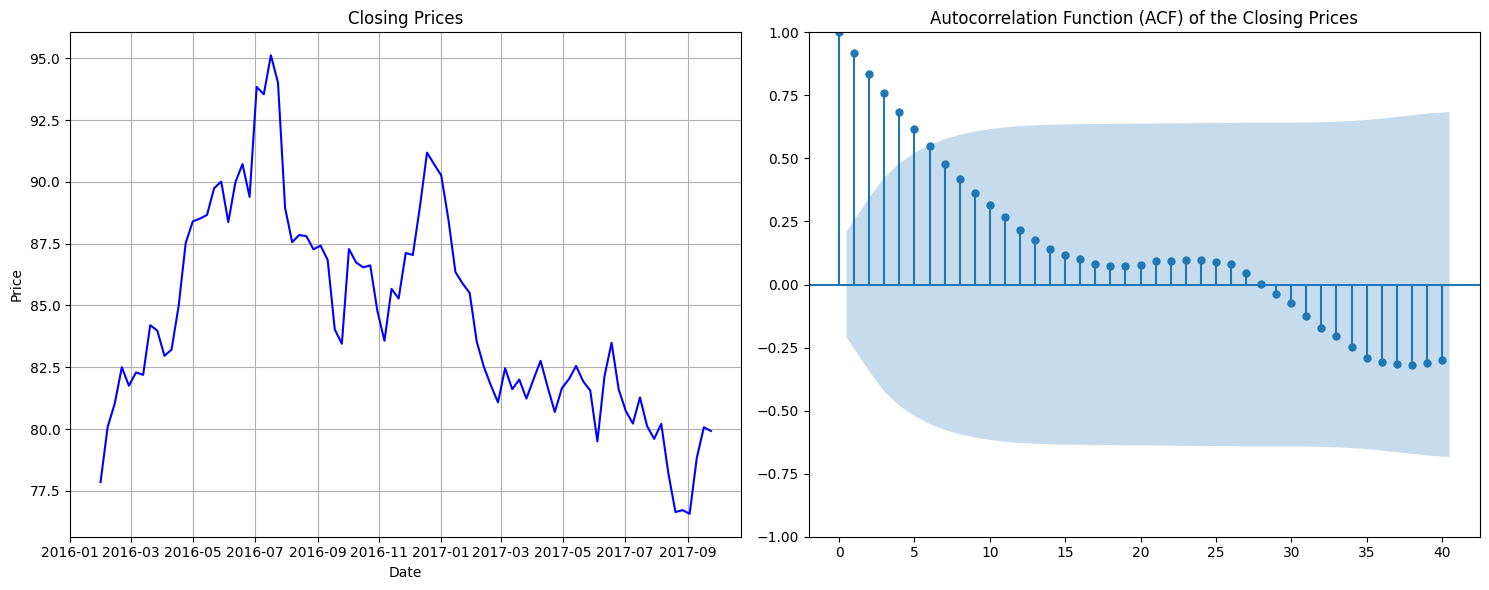

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

# Create a figure with 2 subplots (one for the price and one for the ACF)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the closing prices (Price vs Time)
axes[0].plot(train_data.index, train_data['PRC'], label="Closing Price", color='blue')
axes[0].set_title("Closing Prices")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Price")
axes[0].grid(True)

# Plot the ACF for the 'PRC' column (on the second subplot)
plot_acf(train_data['PRC'].dropna(), lags=40, ax=axes[1])  # lags=40 shows the ACF for up to 40 lags
axes[1].set_title('Autocorrelation Function (ACF) of the Closing Prices')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plot
plt.show()


In [9]:
#Significant MA Lags
acf_coef = acf(train_data['PRC'].dropna(), alpha=.05)
sig_acf = []
for i in range(1, len(acf_coef[0])):
    if acf_coef[0][i] > (acf_coef[1][i][1] - acf_coef[0][i]):
        sig_acf.append(i)
    elif acf_coef[0][i] < (acf_coef[1][i][0] - acf_coef[0][i]):
        sig_acf.append(i)

sig_acf

[1, 2, 3, 4, 5]

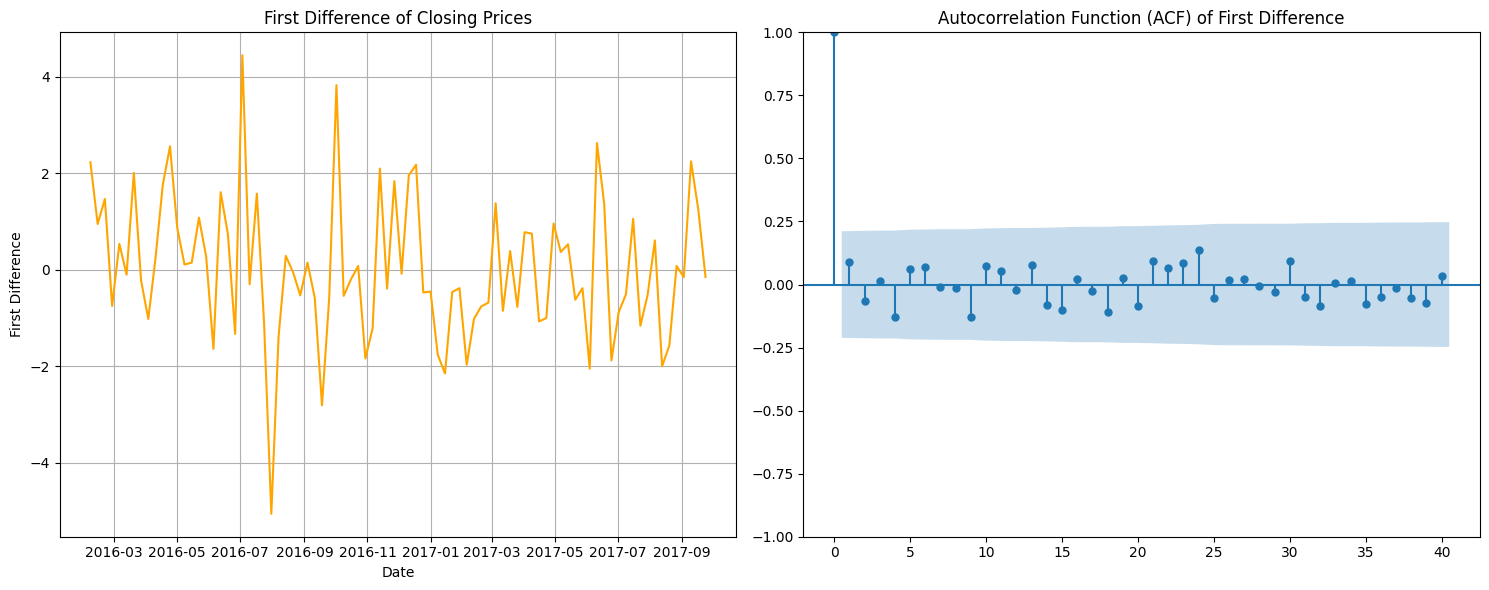

In [10]:
# Calculate the first difference of the closing prices
train_data = train_data.copy()  # Ensure train_data is a separate copy
train_data.loc[:, 'first_difference'] = train_data['PRC'].diff()

train_data.loc[:, 'first_difference'] = train_data['PRC'].diff()

# Create a figure with 2 subplots (one for the first difference and one for the ACF)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the first difference (First Difference vs Time)
axes[0].plot(train_data.index, train_data['first_difference'], label="First Difference", color='orange')
axes[0].set_title("First Difference of Closing Prices")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("First Difference")
axes[0].grid(True)

# Plot the ACF for the first difference (on the second subplot)
plot_acf(train_data['first_difference'].dropna(), lags=40, ax=axes[1])  # dropna() to avoid NaN values
axes[1].set_title('Autocorrelation Function (ACF) of First Difference')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plot
plt.show()


In [11]:
from pmdarima.arima.utils import ndiffs

# Remove missing values (NaN) from the 'PRC' column
cleaned_prc = train_data['PRC'].dropna()

# Find the number of differences (d) needed to make the series stationary
ndiffs_value = ndiffs(cleaned_prc)

# Print the result
print(f"Optimal number of differences (d): {ndiffs_value}")


Optimal number of differences (d): 1


<Figure size 1000x600 with 0 Axes>

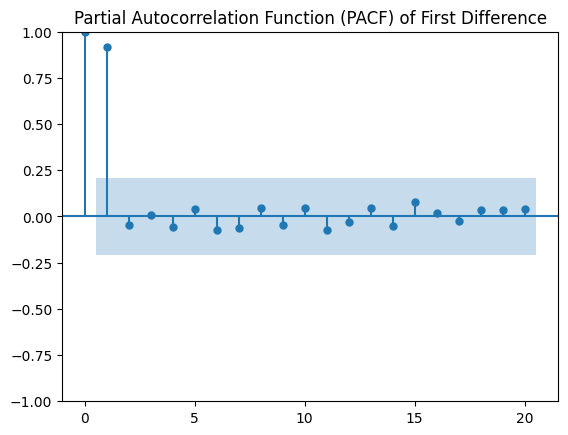

In [12]:
# p is the order of the autoregressive term

from statsmodels.graphics.tsaplots import plot_pacf

# Plot the PACF for the first difference
plt.figure(figsize=(10, 6))
plot_pacf(train_data['PRC'].dropna(), lags=20)  # dropna() to avoid NaN values
plt.title('Partial Autocorrelation Function (PACF) of First Difference')
plt.show()


In [13]:
#Significant AR lags:
pacf_coef = pacf(train_data['PRC'].dropna(), alpha=.05)
sig_pacf = []

for i in range(1, len(pacf_coef[0])):
    if pacf_coef[0][i] > (pacf_coef[1][i][1] - pacf_coef[0][i]):
        sig_pacf.append(i)
    elif pacf_coef[0][i] < (pacf_coef[1][i][0] - pacf_coef[0][i]):
        sig_pacf.append(i)

sig_pacf

[1]

In [14]:
from statsmodels.tsa.arima.model import ARIMA

train_data = train_data.asfreq(f)  # 'D' stands for daily frequency
test_data = test_data.asfreq(f)  # 'D' stands for daily frequency

# Fit an ARIMA model (AR(2), I(1), MA(2)) based on the PACF
model = ARIMA(train_data['PRC'], order=(30, 1, sig_acf[-1]))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                    PRC   No. Observations:                   87
Model:                ARIMA(30, 1, 5)   Log Likelihood                -140.593
Date:                Fri, 11 Apr 2025   AIC                            353.186
Time:                        08:56:47   BIC                            441.542
Sample:                    01-31-2016   HQIC                           388.745
                         - 09-24-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4807     25.271     -0.019      0.985     -50.010      49.049
ar.L2         -0.4340     32.773     -0.013      0.989     -64.667      63.799
ar.L3          0.3389     38.368      0.009      0.9

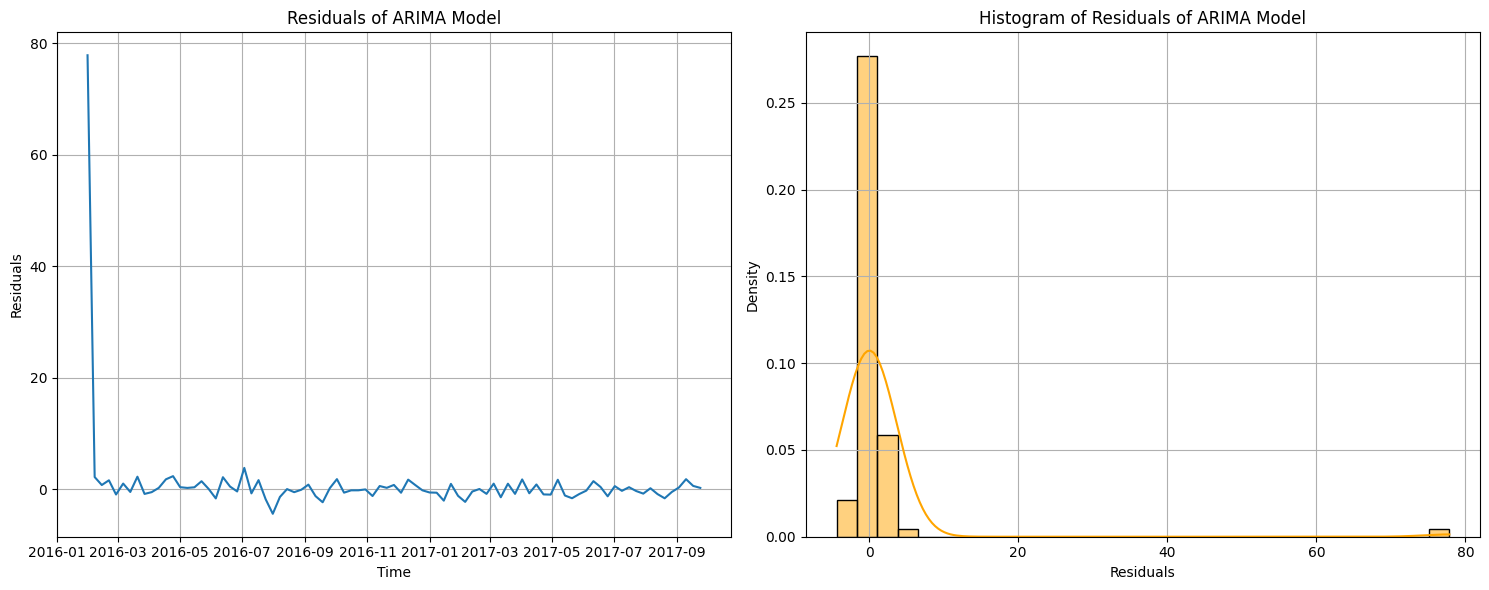

In [15]:
# Get the residuals (difference between observed and fitted values)
residuals = model_fit.resid

# Create a figure with 2 subplots (one for residuals and one for histogram)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the residuals
axes[0].plot(residuals)
axes[0].set_title('Residuals of ARIMA Model')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Residuals')
axes[0].grid(True)

# Plot the histogram of residuals
sns.histplot(residuals, kde=True, bins=30, color='orange', stat='density', ax=axes[1])  # KDE = Kernel Density Estimation
axes[1].set_title('Histogram of Residuals of ARIMA Model')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Density')
axes[1].grid(True)

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.show()

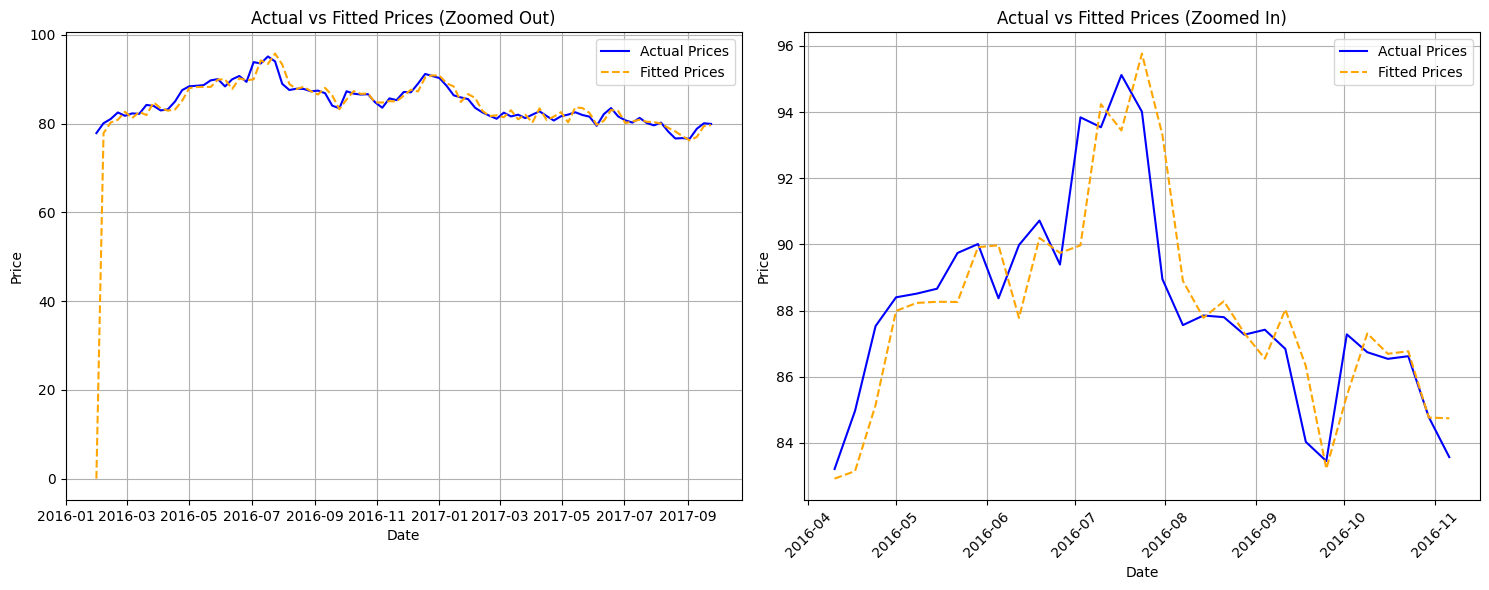

In [16]:
# Get the fitted values (predicted prices)
fitted_values = model_fit.fittedvalues

# Define the range of dates for the zoomed-in plot
start_date = train_data.index[10]  # Adjust this index to the start of your desired section
end_date = train_data.index[40]   # Adjust this index to the end of your desired section

# Create a figure with 2 subplots (zoomed-out and zoomed-in)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the zoomed-out actual vs fitted prices (full range)
axes[0].plot(train_data.index, train_data['PRC'], label='Actual Prices', color='blue')
axes[0].plot(train_data.index, fitted_values, label='Fitted Prices', color='orange', linestyle='--')
axes[0].set_title('Actual vs Fitted Prices (Zoomed Out)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True)

# Plot the zoomed-in actual vs fitted prices (subset of data)
axes[1].plot(train_data.loc[start_date:end_date].index, train_data.loc[start_date:end_date, 'PRC'], label='Actual Prices', color='blue')
axes[1].plot(train_data.loc[start_date:end_date].index, fitted_values.loc[start_date:end_date], label='Fitted Prices', color='orange', linestyle='--')
axes[1].set_title('Actual vs Fitted Prices (Zoomed In)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price')
axes[1].legend()
axes[1].grid(True)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plot
plt.show()


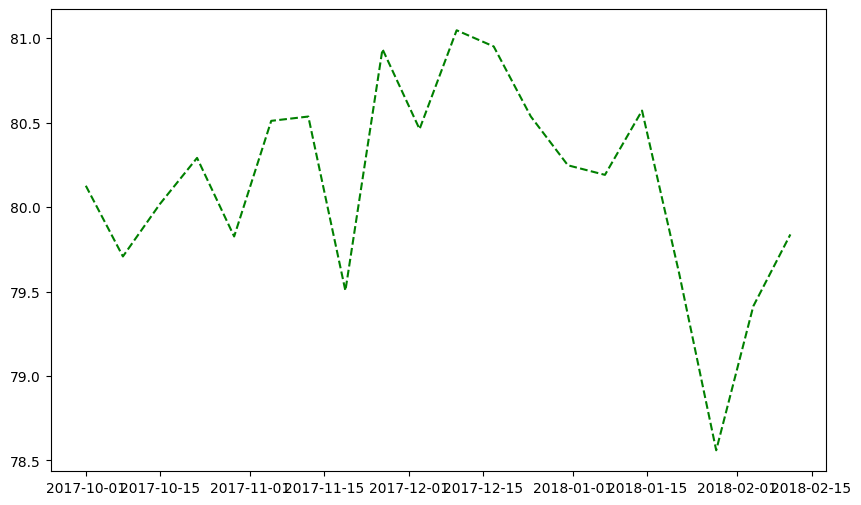

In [17]:
# Forecast the next 60 steps beyond the training data (e.g., 60 future periods)
forecast_steps = 20
forecast_results = model_fit.get_forecast(steps=forecast_steps)

# Forecasted values
forecast_values = forecast_results.predicted_mean

plt.figure(figsize=(10, 6))

# Plot the forecasted values (future predictions beyond the training period)
forecast_index = pd.date_range(train_data.index[-1], periods=forecast_steps + 1, freq=f)[1:]  # Generate future dates


plt.plot(forecast_index, forecast_values, label='Forecasted Prices', color='green', linestyle='--')


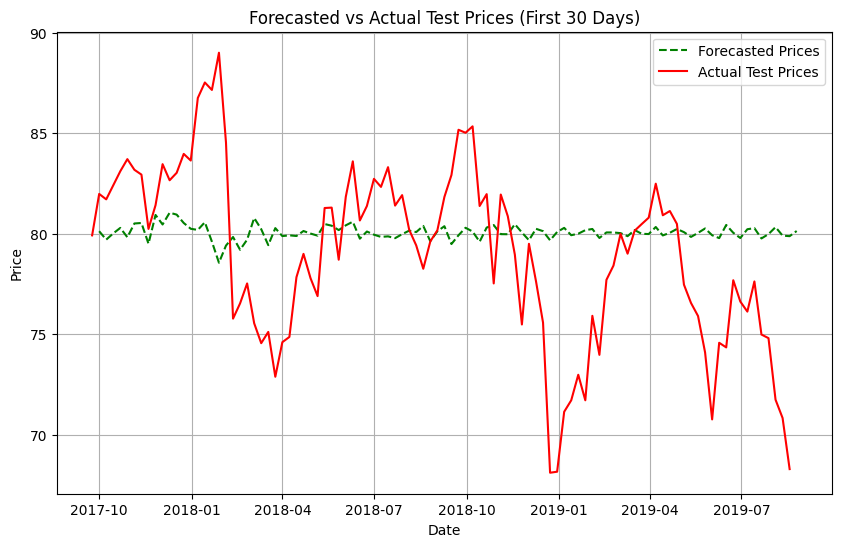

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Forecast the next 30 steps beyond the training data (e.g., 30 future periods)
forecast_steps = 100
forecast_results = model_fit.get_forecast(steps=forecast_steps)

# Forecasted values
forecast_values = forecast_results.predicted_mean

# Generate future dates for the forecasted values
forecast_index = pd.date_range(train_data.index[-1], periods=forecast_steps + 1, freq=f)[1:]

# Slice the test data to only the first 30 days
test_data_30 = test_data['PRC'].iloc[:forecast_steps] 

# Plotting the forecasted values and actual data
plt.figure(figsize=(10, 6))

# Plot the forecasted values (future predictions beyond the training period)
plt.plot(forecast_index, forecast_values[:forecast_steps], label='Forecasted Prices', color='green', linestyle='--')

# Plot the actual test data (first 30 days)
plt.plot(test_data_30.index, test_data_30, label='Actual Test Prices', color='red')

# Customize the plot
plt.title('Forecasted vs Actual Test Prices (First 30 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


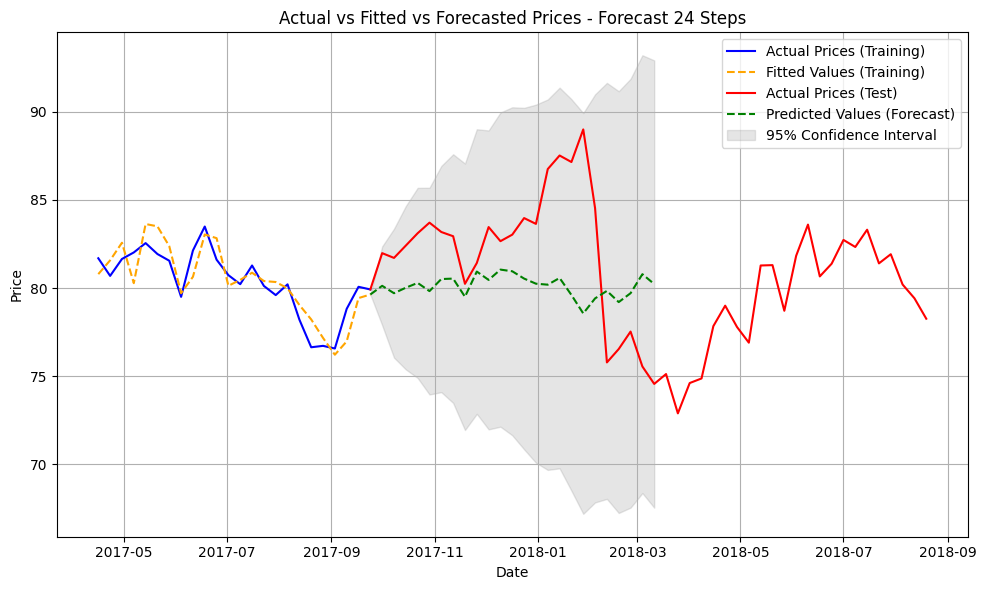

In [19]:
# Define the number of steps you want to forecast
forecast_steps = 24 # You can change this value to whatever number of steps you want

# Forecast the next 'forecast_steps' values (out-of-sample prediction)
forecast_results = model_fit.get_forecast(steps=forecast_steps)

# Forecasted values
forecast_values = forecast_results.predicted_mean

# Append the last fitted value to the front of the forecasted values
x = model_fit.fittedvalues.iloc[-1]
forecast_values = pd.concat([pd.Series(x), forecast_values], ignore_index=True)

# Confidence intervals for the forecast
conf_int = forecast_results.conf_int(alpha=0.05)
init_row = pd.DataFrame([[x, x]], columns=conf_int.columns)  # Initialise both bounds
conf_int = pd.concat([init_row, conf_int], ignore_index=True)

# Filter the data for the post-2018 period
train_data_filtered = train_data.iloc[-24:]


# Create the plot (only the right side for post-2018)
fig, ax = plt.subplots(figsize=(10, 6))

# Plot actual vs fitted vs forecasted values for the post-2018 period
ax.plot(train_data_filtered.index, train_data_filtered['PRC'], label='Actual Prices (Training)', color='blue')
ax.plot(train_data_filtered.index, model_fit.fittedvalues.loc[train_data_filtered.index], label='Fitted Values (Training)', color='orange', linestyle='--')
ax.plot(test_data.index[:(forecast_steps*2)], test_data['PRC'][:(forecast_steps*2)], label='Actual Prices (Test)', color='red')
ax.plot(test_data.index[:forecast_steps+1], forecast_values, label='Predicted Values (Forecast)', color='green', linestyle='--')
ax.fill_between(test_data.index[0:forecast_steps+1], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2, label='95% Confidence Interval')

# Customize the plot
ax.set_title(f'Actual vs Fitted vs Forecasted Prices - Forecast {forecast_steps} Steps')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()
ax.grid(True)

# Display the plot
plt.tight_layout()
plt.show()



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters f

RMSE of first 24-step rolling forecast: 2.3270944998298964


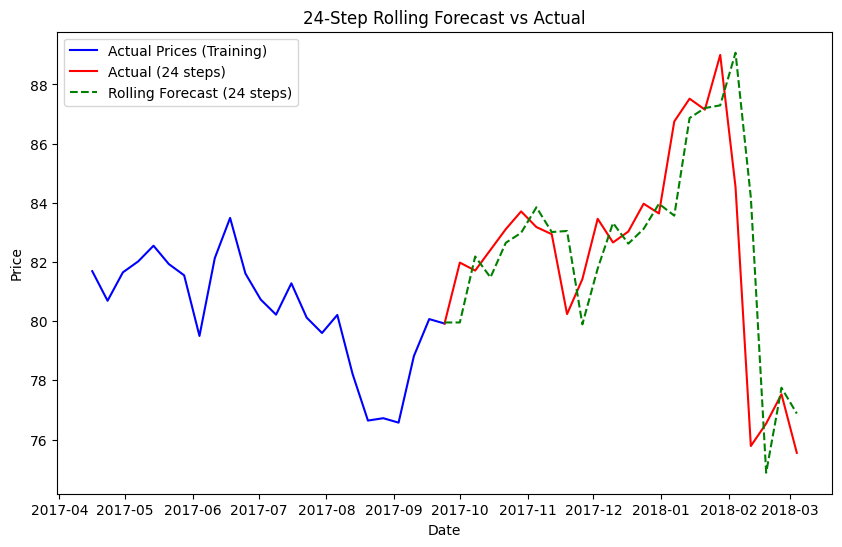

In [20]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Assuming 'train_data' and 'test_data' are already defined as in your previous code
# and that they contain a 'PRC' column indexed by dates.

p, d, q = 2, 1, 1  # Example ARIMA order, adjust as needed

train_series = train_data['PRC']
test_series = test_data['PRC']

predictions = []
actuals = []

history = train_series.copy()  # Start with the training portion of the data
test_dates = test_series.index

# Perform a rolling forecast for the first 24 steps of the test set
for t in test_dates[:24]:
    # Fit the ARIMA model on the current history
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()
    
    # Forecast the next step (1-step ahead)
    forecast = model_fit.forecast(steps=1)
    predicted_value = forecast.iloc[0]
    predictions.append(predicted_value)
    
    # Get the actual value from the test set at time t
    actual_value = test_series.loc[t]
    actuals.append(actual_value)
    
    # Add this actual value to the history for the next iteration
    history.loc[t] = actual_value

# Convert predictions and actuals into Series for easy handling
predictions = pd.Series(predictions, index=test_dates[:24])
actuals = pd.Series(actuals, index=test_dates[:24])

# Compute RMSE
errors = actuals - predictions
rmse = np.sqrt((errors**2).mean())
print(f"RMSE of first 24-step rolling forecast: {rmse}")

# Plot only the 24 forecast steps and the actual values
plt.figure(figsize=(10, 6))
plt.plot(train_data_filtered.index, train_data_filtered['PRC'], label='Actual Prices (Training)', color='blue')
plt.plot(actuals.index, actuals, label='Actual (24 steps)', color='red')
plt.plot(predictions.index, predictions, label='Rolling Forecast (24 steps)', color='green', linestyle='--')
plt.title('24-Step Rolling Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

RMSE of the 48-step batch rolling forecast (n=4): 3.2685839709173834


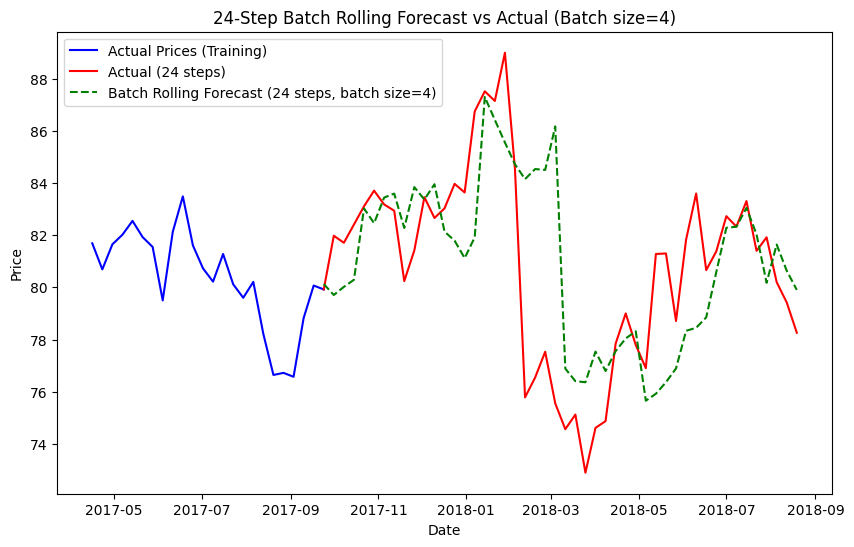

In [21]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Assume train_data and test_data are already defined and have a 'PRC' column
p, d, q = 30, 1, sig_acf[-1]   # Example ARIMA order, adjust as needed
n = 4                # Batch size (number of steps to forecast before updating)

train_series = train_data['PRC']
test_series = test_data['PRC']
test_dates = test_series.index

history = train_series.copy()
predictions = []
actuals = []

# We'll do a batch forecast for the first (up to) 24 steps as an example
forecast_steps = 48
num_batches = int(np.ceil(forecast_steps / n))

for batch_i in range(num_batches):
    # Compute how many steps to forecast in this batch
    steps_left = forecast_steps - batch_i * n
    steps_to_forecast = min(n, steps_left)
    
    if steps_to_forecast <= 0:
        break
    
    # Fit (or refit) the model on the current history
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()
    
    # Forecast next n steps
    forecast = model_fit.forecast(steps=steps_to_forecast)
    
    # Identify the portion of the test set we are predicting
    batch_start = batch_i * n
    batch_end = batch_start + steps_to_forecast
    forecast_dates = test_dates[batch_start:batch_end]
    
    # Store predictions
    batch_predictions = pd.Series(forecast.values, index=forecast_dates)
    predictions.append(batch_predictions)
    
    # Get the actual values for these steps
    batch_actuals = test_series.loc[forecast_dates]
    actuals.append(batch_actuals)
    
    # "See" the new actual data and update the history
    # Now that these periods have passed and actual data is available
    for dt, val in batch_actuals.items():
        history.loc[dt] = val

# Concatenate all batches into single series
predictions = pd.concat(predictions)
actuals = pd.concat(actuals)

# Compute RMSE over the forecast_steps
errors = actuals - predictions
rmse = np.sqrt((errors**2).mean())
print(f"RMSE of the {forecast_steps}-step batch rolling forecast (n={n}): {rmse}")

# Plot only the 24-step forecast and the corresponding actual values
plt.figure(figsize=(10, 6))
plt.plot(train_data_filtered.index, train_data_filtered['PRC'], label='Actual Prices (Training)', color='blue')
plt.plot(actuals.index, actuals, label='Actual (24 steps)', color='red')
plt.plot(predictions.index, predictions, label=f'Batch Rolling Forecast (24 steps, batch size={n})', 
         color='green', linestyle='--')
plt.title(f'24-Step Batch Rolling Forecast vs Actual (Batch size={n})')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
